<a href="https://colab.research.google.com/github/ydpajaro/Miniproyecto2/blob/main/miniproyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Para el sistema de Análisis Multivariado de Señales Sismográficas obtenido en el Primer Mini-Proyecto, se debe construir un módulo de variable latente utilizando el algorítmo de PCA. La idea es proyectar la matriz característica obtenida $\mathbf{X} \in \mathbb{R}^{N \times D}$, a un espacio latente de menor dimensión $q<<D$, de tal forma que los nuevos datos en este espacio sean $\mathbf{Z} \in \mathbb{R}^{N \times q}$. Selecciones diferentes configuraciones del número de componentes $q$ y evalúe el mejor desempeño arrojado por el modelo midiendo, el accuracy y la matriz de confusión. Para ellos:

  (a) Realice la visualización de las componentes en el espacio latente para diferentes configuraciones de $q$. ¿Que puede observar al respecto?

In [132]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from ipywidgets import interact

In [133]:
#Se crea una url para posteriormente importar el archivo a Colab.
url = 'https://raw.githubusercontent.com/ydpajaro/Miniproyecto2/main/datos.csv'


In [134]:
#Cargamos el data set
df = pd.read_csv(url)
df #lectura del data set


,energia,potencia_max,frecuencia_potencia_max,media_espectro,var_espectro,max_espectro,entropia,min_espectro,no_cero_crossing,no_mean_crossing,n5,n25,n75,n95,mediana,media,std,varianza,rms,Tipo_Sismo
0,2.453833e+01,1.215966e-04,3.90625,1.277524e-04,5.301983e-06,0.146451,5.307721e-22,9.605620,204.0,195.0,-1.532338e-02,-1.873980e-04,3.472018e-04,2.293197e-02,2.066902e-12,2.804791e-04,0.040652,1.652557e-03,1.118556e-02,sisLoc
1,8.564020e-04,2.300617e-09,39.06250,1.995403e-06,2.059800e-10,0.000409,2.412856e-25,9.605620,468.0,451.0,-1.658915e-04,-3.784440e-09,1.310257e-08,1.720937e-04,7.954222e-16,-4.570735e-07,0.000240,5.767773e-08,5.474878e-05,sisLoc
2,2.880990e-08,8.457749e-14,46.87500,1.360911e-08,6.728885e-15,0.000002,1.951416e-27,9.605620,624.0,605.0,-1.158634e-06,-1.808234e-10,8.316053e-11,1.184125e-06,-2.194506e-18,-2.630612e-09,0.000001,1.940315e-12,3.675901e-07,sisLoc
3,3.207340e+01,1.605253e-04,3.90625,1.212212e-04,6.937409e-06,0.168203,1.163691e-20,9.605620,182.0,172.0,-1.722534e-02,-3.344018e-04,1.247302e-04,1.840137e-02,-1.865526e-11,-1.025060e-04,0.046477,2.160105e-03,1.178870e-02,sisLoc
4,8.979448e-04,2.816926e-09,39.06250,1.378747e-06,2.261553e-10,0.000488,1.606779e-25,9.605620,427.0,409.0,-1.002054e-04,-3.544687e-09,1.386522e-08,1.001184e-04,9.536273e-16,3.116154e-07,0.000246,6.047571e-08,3.501850e-05,sisLoc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1.926256e-03,2.967362e-09,31.25000,1.660664e-06,1.980359e-10,0.000472,1.728175e-31,10.373491,1170.0,1143.0,-2.037452e-04,-1.745988e-06,3.025358e-06,1.990628e-04,6.981364e-22,3.822240e-08,0.000245,6.019549e-08,7.668686e-05,SisTel
185,3.375983e-08,4.714812e-14,50.78125,7.353717e-09,3.654347e-15,0.000003,1.183745e-32,10.373491,1603.0,1575.0,-7.761713e-07,-1.743021e-08,3.027556e-08,7.490469e-07,6.110454e-24,1.371131e-10,0.000001,1.054995e-12,2.960438e-07,SisTel
186,3.892099e+01,7.931400e-05,3.90625,1.669969e-04,3.854130e-06,0.171831,1.273462e-15,10.373491,1109.0,1109.0,-2.556461e-02,-4.035743e-03,4.038336e-03,2.518270e-02,1.376711e-06,-6.915840e-06,0.034875,1.216281e-03,1.205614e-02,SisTel
187,2.440055e-03,3.053793e-09,35.15625,2.640148e-06,2.427051e-10,0.000491,3.269328e-21,10.373491,2053.0,2047.0,-3.360618e-04,-5.618561e-05,5.669137e-05,3.298703e-04,9.460301e-11,6.486854e-08,0.000276,7.625171e-08,1.266245e-04,SisTel


In [135]:
# Selecciona todas las filas y todas las columnas excepto la última (que contiene las etiquetas) del DataFrame 'df'
# y se guarda como una matriz NumPy llamada 'X'
X = df.iloc[:, :-1].values
# Selecciona la columna 'Tipo_Sismo' del DataFrame 'df' y se guarda como una matriz NumPy llamada 'y'
y = df['Tipo_Sismo'].values

Accuracy con 2 componentes: 0.789


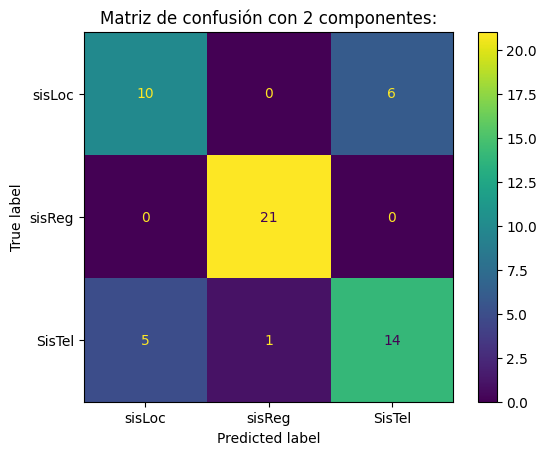


Accuracy con 5 componentes: 0.842


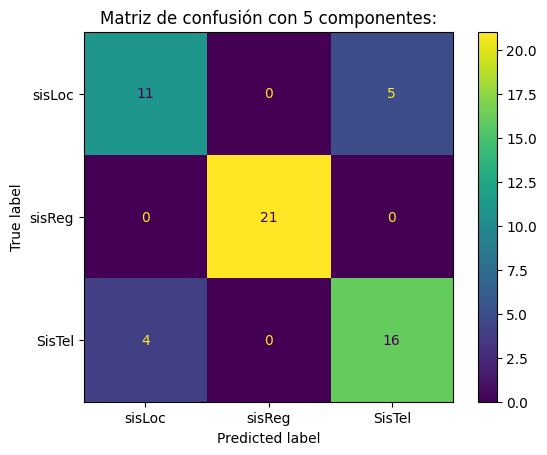


Accuracy con 10 componentes: 0.842


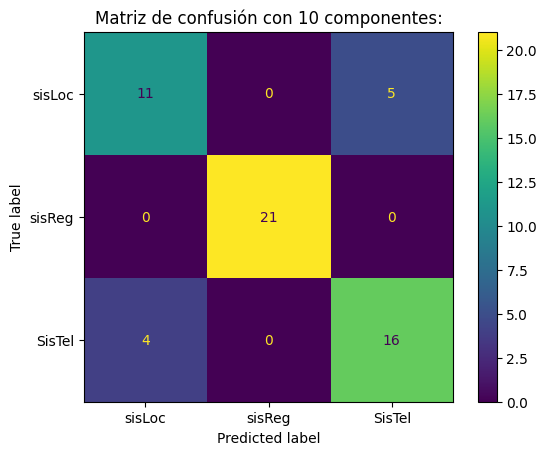


Accuracy con 15 componentes: 0.842


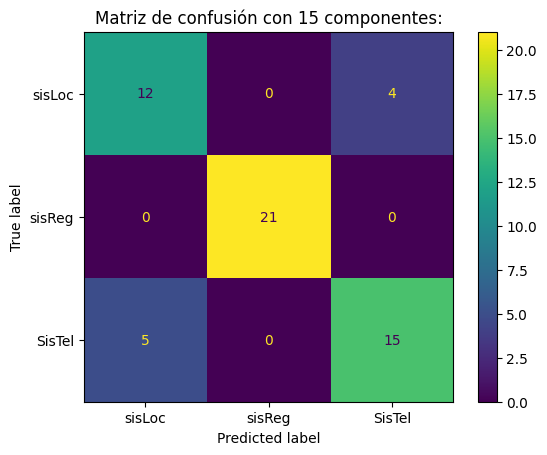


Accuracy con 19 componentes: 0.842


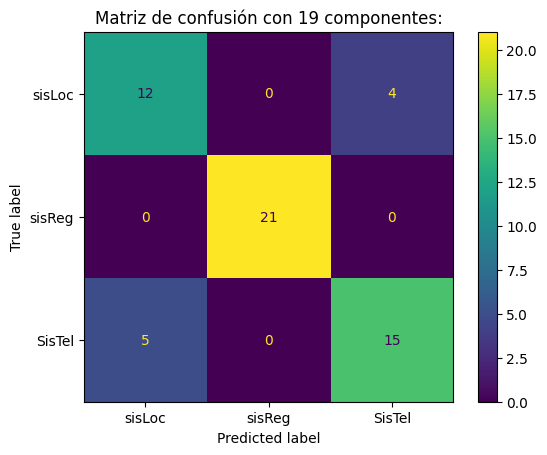

In [136]:
# Normalizar los datos
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Proyectar los datos en el espacio latente de diferentes dimensiones
q_values = [2, 5, 10, 15, 19]
acc_values = []
for q in q_values:
    # Proyectar los datos en el espacio latente
    pca = PCA(n_components=q)
    Z = pca.fit_transform(X_norm)

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=42)

    # Entrenar un modelo de clasificación
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # Evaluar el desempeño del modelo
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    acc_values.append(acc)
    # conf_matrices.append(conf)
 
    # Imprimir los resultados
    print('Accuracy con %d componentes: %.3f' % (q, acc))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels = df['Tipo_Sismo'].unique())
    disp.plot()
    plt.title('Matriz de confusión con %d componentes:' % q)
    plt.show()
    print()


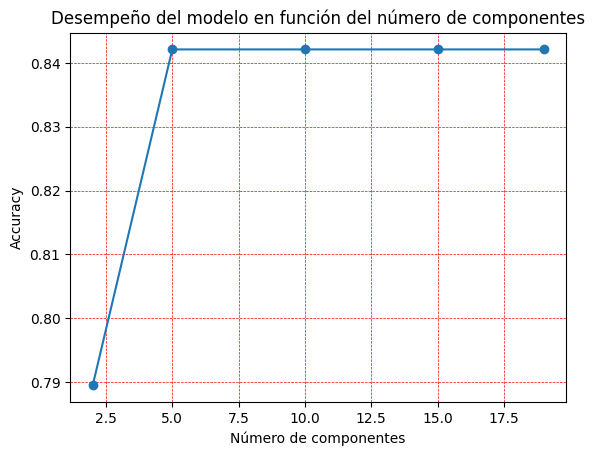

In [137]:
# Graficar el desempeño del modelo en función del número de componentes
plt.plot(q_values, acc_values, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Accuracy')
plt.title('Desempeño del modelo en función del número de componentes')
plt.grid(color='r', linestyle='--', linewidth=0.5)
plt.show()

En general, los resultados muestran que el modelo de PCA tiene un buen desempeño en la tarea de clasificación, con una precisión promedio del 84%. Las matrices de confusión obtenidas a partir de diferentes configuraciones de componentes son bastante similares, lo que sugiere que incluso un modelo con solo 2 o 5 componentes puede tener un buen desempeño. Además, el desempeño del modelo PCA no parece mejorar significativamente a medida que se aumenta el número de componentes, lo que sugiere que un modelo con una cantidad reducida de componentes puede ser suficiente. Además, se puede notar que en la clase 2 no hubo errores de clasificación en ningún modelo, mientras que en las clases 1 y 3 se presentaron algunos errores en la predicción. En la clase 1 se presentaron más falsos negativos, lo que indica que esta clase puede ser más difícil de clasificar en comparación con las otras dos.


  (b) Entrene dos modelos lineales de clasificación Bayesiano y Regresión Logística, con el fin de evaluar el desempeño en el reconocimiento de los tipos de sismos tanto en el espacio de entrada (sin utilizar PCA), cómo en el espacio latente.

Accuracy del modelo de clasificación Bayesiano con 2 componentes: 0.351
Accuracy del modelo de regresión logística con 2 componentes: 0.316


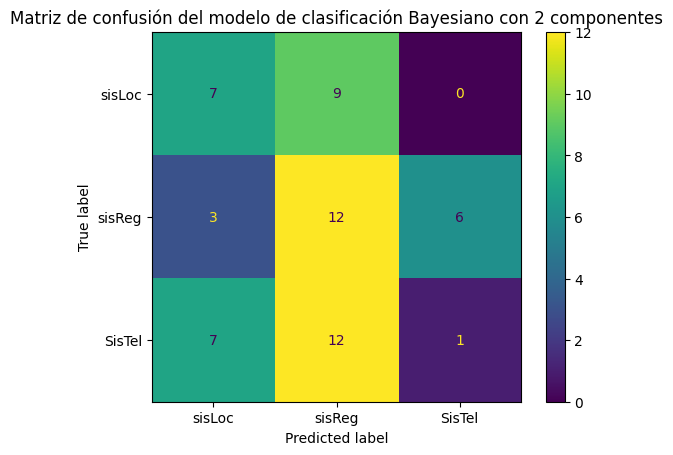

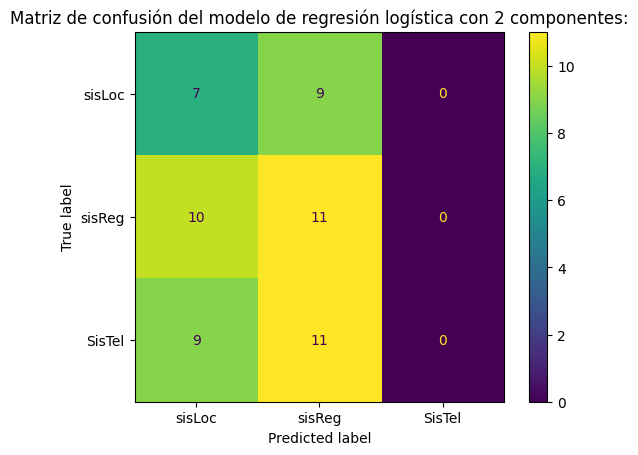

Accuracy del modelo de clasificación Bayesiano con 5 componentes: 0.351
Accuracy del modelo de regresión logística con 5 componentes: 0.404


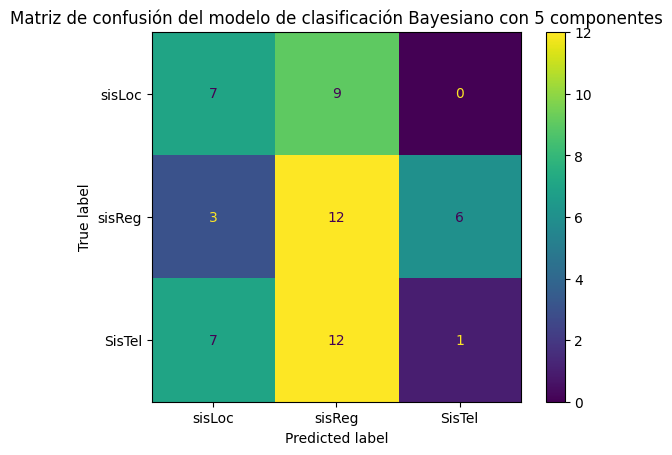

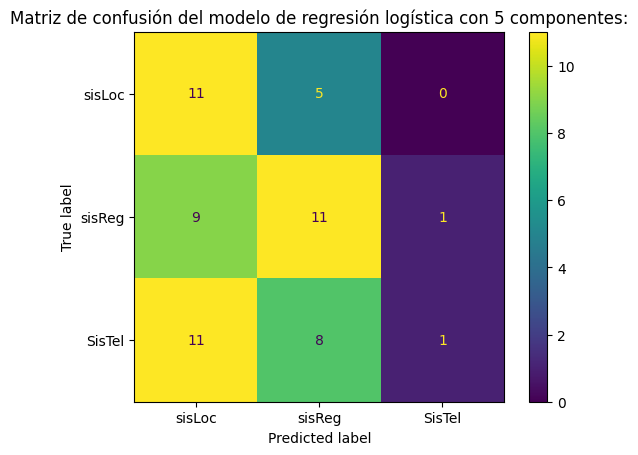

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy del modelo de clasificación Bayesiano con 10 componentes: 0.930
Accuracy del modelo de regresión logística con 10 componentes: 0.789


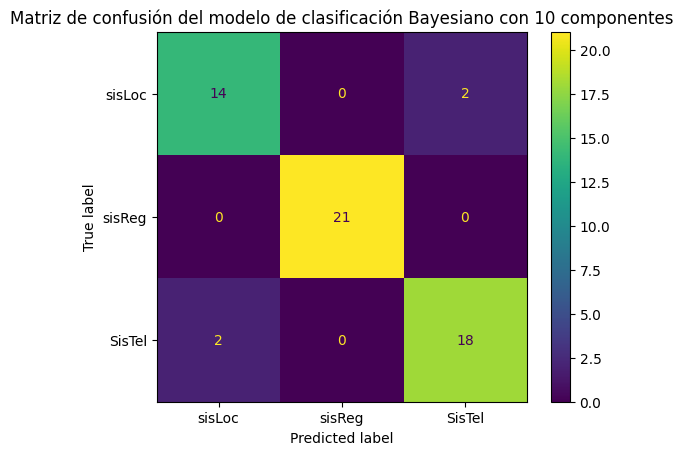

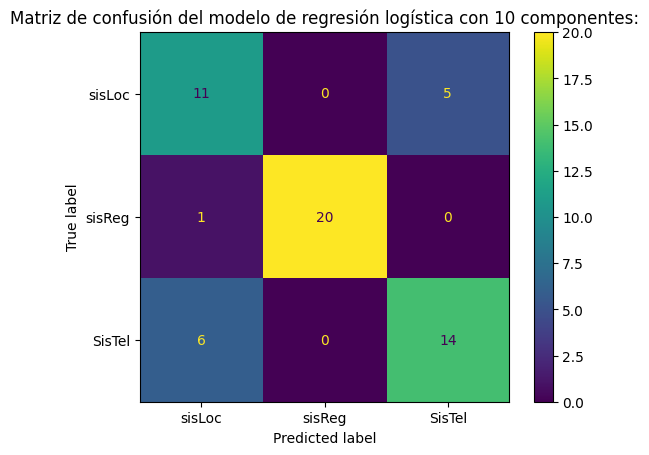

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy del modelo de clasificación Bayesiano con 15 componentes: 0.930
Accuracy del modelo de regresión logística con 15 componentes: 0.825


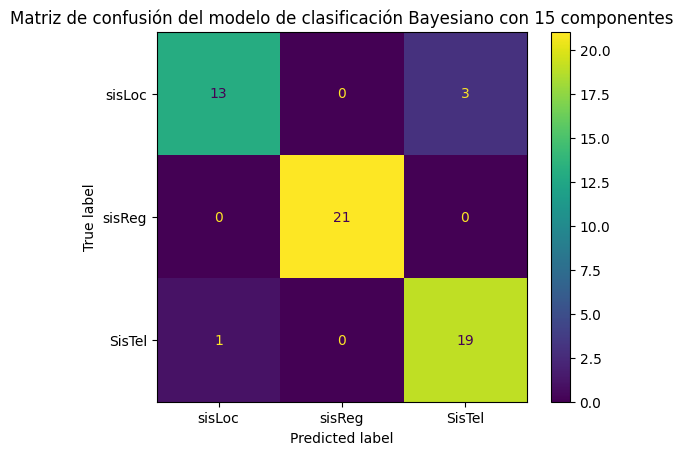

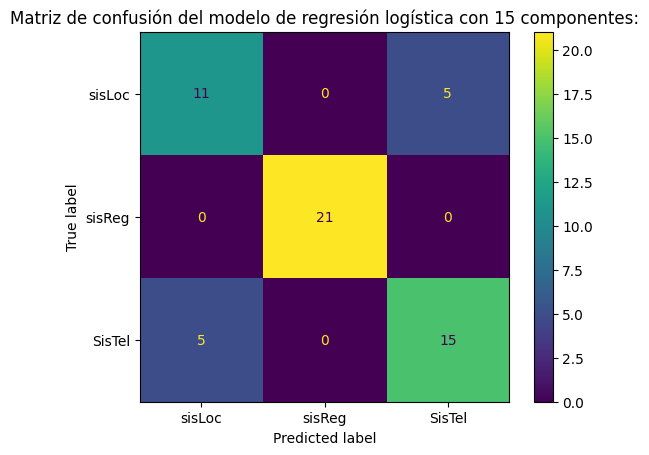

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy del modelo de clasificación Bayesiano con 19 componentes: 0.930
Accuracy del modelo de regresión logística con 19 componentes: 0.825


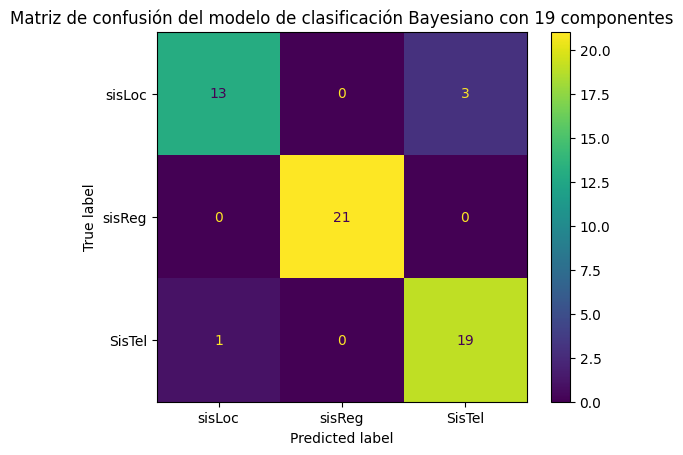

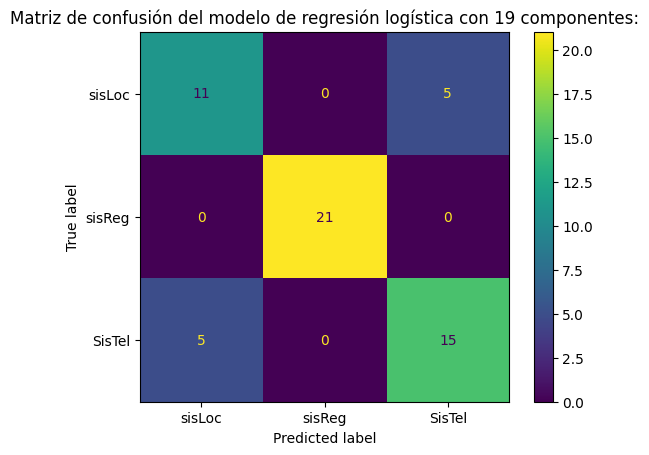

In [138]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


q_values = [2, 5, 10, 15, 19]
acc_values_gnb = []
acc_values_lr = []
for q in q_values:
  # Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X[:,:q], y, test_size=0.3, random_state=42)

  # Entrenar el modelo de clasificación Bayesiano
  gnb = GaussianNB()
  gnb.fit(X_train, y_train)

  # Entrenar el modelo de regresión logística
  lr = LogisticRegression()
  lr.fit(X_train, y_train)

  # Predecir las etiquetas en el conjunto de prueba
  y_pred_gnb = gnb.predict(X_test)
  y_pred_lr = lr.predict(X_test)

  # Evaluar el desempeño de los modelos
  acc_gnb = accuracy_score(y_test, y_pred_gnb)
  acc_values_gnb.append(acc_gnb)
  acc_lr = accuracy_score(y_test, y_pred_lr)
  acc_values_lr.append(acc_lr)
  print('Accuracy del modelo de clasificación Bayesiano con %d componentes: %.3f' % (q, acc_gnb))
  print('Accuracy del modelo de regresión logística con %d componentes: %.3f' % (q, acc_lr))
  
  

  cm_gnb = confusion_matrix(y_test, y_pred_gnb)  
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb,display_labels = df['Tipo_Sismo'].unique())
  disp.plot()
  plt.title('Matriz de confusión del modelo de clasificación Bayesiano con %d componentes' % q)

  cm_lr = confusion_matrix(y_test, y_pred_lr)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels = df['Tipo_Sismo'].unique())
  disp.plot()
  plt.title('Matriz de confusión del modelo de regresión logística con %d componentes:' % q)
  
  plt.show()

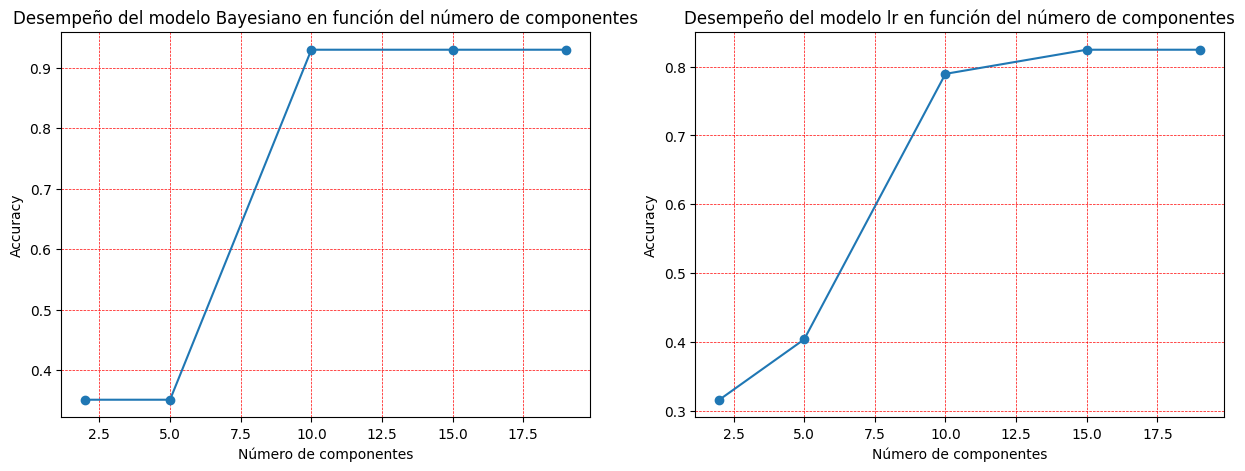

In [139]:
# Graficar el desempeño del modelo en función del número de componentes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(q_values, acc_values_gnb, marker='o')
axs[0].set_xlabel('Número de componentes')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Desempeño del modelo Bayesiano en función del número de componentes')
axs[0].grid(color='r', linestyle='--', linewidth=0.5)


axs[1].plot(q_values, acc_values_lr, marker='o')
axs[1].set_xlabel('Número de componentes')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Desempeño del modelo lr en función del número de componentes')
axs[1].grid(color='r', linestyle='--', linewidth=0.5)

plt.show()


En el análisis presentado se compararon los resultados de dos modelos de clasificación (clasificación Bayesiana y regresión logística) para diferentes números de componentes (2, 5, 10, 15, 19). Al analizar las matrices de confusión para cada modelo y número de componentes, así como la precisión (accuracy) de cada modelo en la tarea de clasificación se observa que la precisión del modelo de clasificación Bayesiano se mantuvo constante para 2 y 5 componentes en 0.351, mientras que la precisión del modelo de regresión logística mejoró a medida que se aumentó el número de componentes. Para 10, 15 y 19 componentes, la precisión del modelo de clasificación Bayesiano fue del 0.930, mientras que la precisión del modelo de regresión logística fue del 0.789, 0.825 y 0.825, respectivamente. Las matrices de confusión revelaron que los modelos presentaron un comportamiento similar en algunas situaciones, como en la clasificación de la segunda clase, donde ambos modelos tuvieron dificultades para clasificar correctamente las muestras. 


<div align="justify"><strong><em>Espacio latente aplicando PCA</em></strong></div>

In [140]:
q_values = [2,5,10,15,19]
for q in q_values:
  # Proyectar los datos en el espacio latente
    pca = PCA(n_components=q)
    Z = pca.fit_transform(X_norm)
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=42)

    # Entrenar el modelo de PCA
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

   

    # Entrenar el modelo de clasificación Bayesiano en el espacio latente PCA
    gnb_pca = GaussianNB()
    gnb_pca.fit(X_train_pca, y_train)
    y_pred_gnb_pca = gnb_pca.predict(X_test_pca)
    acc_gnb_pca = accuracy_score(y_test, y_pred_gnb_pca)
    print('Accuracy con %d  del modelo de clasificación Bayesiano en el espacio latente PCA: %.3f' % (q,acc_gnb_pca))

    lr_pca = LogisticRegression()
    lr_pca.fit(X_train_pca, y_train)
    y_pred_lr_pca = lr_pca.predict(X_test_pca)
    acc_lr_pca = accuracy_score(y_test, y_pred_lr_pca)
    print('Accuracy con %d del modelo de regresión logística en el espacio latente PCA: %.3f' % (q,acc_lr_pca))

Accuracy con 2  del modelo de clasificación Bayesiano en el espacio latente PCA: 0.789
Accuracy con 2 del modelo de regresión logística en el espacio latente PCA: 0.789
Accuracy con 5  del modelo de clasificación Bayesiano en el espacio latente PCA: 0.772
Accuracy con 5 del modelo de regresión logística en el espacio latente PCA: 0.842
Accuracy con 10  del modelo de clasificación Bayesiano en el espacio latente PCA: 0.807
Accuracy con 10 del modelo de regresión logística en el espacio latente PCA: 0.842
Accuracy con 15  del modelo de clasificación Bayesiano en el espacio latente PCA: 0.772
Accuracy con 15 del modelo de regresión logística en el espacio latente PCA: 0.842
Accuracy con 19  del modelo de clasificación Bayesiano en el espacio latente PCA: 0.719
Accuracy con 19 del modelo de regresión logística en el espacio latente PCA: 0.842


 Los resultados muestran que la reducción de la dimensionalidad mediante PCA afecta significativamente el desempeño de los modelos de clasificación, donde la precisión de la clasificación varió de acuerdo al número de componentes principales utilizados. Se observó que la regresión logística tuvo un mejor desempeño que el modelo de clasificación Bayesiano en la mayoría de los casos, con un aumento en la precisión de la clasificación en algunos casos. Estos resultados sugieren que la reducción de la dimensionalidad mediante PCA puede ser útil para mejorar el desempeño de los modelos de clasificación en conjuntos de datos sísmicos, y que la regresión logística puede ser una opción viable para la clasificación de datos sísmicos. Sin embargo, se necesitan estudios adicionales para evaluar el efecto de otras técnicas de reducción de la dimensionalidad y modelos de clasificación en la clasificación de datos sísmicos.

2. En el problema de reconocimiento de rostros, un algoritmo muy utilizado se conoce como EigenFaces, el cual consiste en proyectar las imágenes de los rostros de interés en un espacio de menor dimensionalidad utilizando enfoques de variables latentes lineales como lo es PCA (Face recognition using eigenfaces). Su tarea aquí, es implementar el modelo de PCA y observar los resultados en el reconocimiento para la clasificación utilizando el modelo Regresión Logística. Realice una validación de los experimentos realizando variaciones de parámetros en el número de componentes y en los parámetros que intervienen en el clasificador.

  (a) ¿Cómo lucen los rostros proyectados en ambos espacios latentes?. Implemente su visualización.

  (b) ¿Qué puede evidenciar en el desempeño del nuevo modelo de reconocimiento (Incluir PCA) para esta tarea?

In [141]:
#Importar librerias
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [142]:
# Cargar la base de datos fetch_lfw_people y las etiquetas correspondientes
"""
Se utiliza para especificar que solo se incluyan en la base de datos aquellas 
personas que tengan al menos 100 imágenes. Esto se hace para asegurarse de que 
haya suficientes muestras para entrenar un modelo de aprendizaje automático.
"""
faces = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

x = faces.data #datos de las imágenes
y = faces.target #etiquestas que identifican la persona que aparece en cada imagen

In [143]:
# Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [144]:
#Normalización del conjunto de datos
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [145]:
# Crear objeto PCA con el número de componentes deseados, 150 para este caso
pca = PCA(n_components=150, svd_solver="randomized", whiten=True)

# Ajustar PCA a los datos de entrenamiento
pca.fit(x_train)

# Transformar los datos de entrenamiento y prueba al espacio de menor dimensión
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [146]:
# Entrenar el modelo de Regresión Logística utilizando los datos de entrenamiento
model = LogisticRegression(random_state=0, max_iter=2000)
model.fit(x_train_pca, y_train)

#Calcular accuracy del modelo en el conjunto de prueba
y_pred = model.predict(x_test_pca)
acc = accuracy_score(y_test, y_pred)

# Imprimir accuracy
print("Accuracy: {:.2f}".format(acc))

Accuracy: 0.86


In [147]:
print(classification_report(y_test,y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.83      0.79      0.81        43
  Donald Rumsfeld       0.89      0.83      0.86        30
    George W Bush       0.90      0.89      0.89       108
Gerhard Schroeder       0.76      0.81      0.79        16
       Tony Blair       0.77      0.87      0.82        31

         accuracy                           0.86       228
        macro avg       0.83      0.84      0.83       228
     weighted avg       0.86      0.86      0.86       228



Para cada clase, el informe de clasificación muestra la precisión, el recall y el F1-score. La precisión es la fracción de predicciones positivas que son correctas, mientras que el recall es la fracción de instancias positivas que se identifican correctamente. El F1-score es una medida que combina tanto la precisión como el recall en una sola métrica.

El modelo clasificó imágenes de cinco personas diferentes: Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder y Tony Blair. El modelo tuvo un accuracy global del 86%, lo que significa que clasificó correctamente el 86% de las imágenes del conjunto de prueba.

En términos de métricas para cada clase, el modelo tuvo una precisión, recall y f1-score altos para Colin Powell, George W Bush y Gerhard Schroeder. Para Donald Rumsfeld, tuvo una precisión y recall  altos, lo que indica que el modelo tuvo más facilidad para clasificar las imágenes de esta persona. Para Tony Blair, el modelo tuvo un recall alto pero una precisión más baja, lo que sugiere que el modelo clasificó algunas imágenes incorrectamente como Tony Blair.

En general, este informe de clasificación sugiere que el modelo de clasificación se desempeña bien en la clasificación de las imágenes de caras de políticos específicos. Sin embargo, es importante tener en cuenta que la precisión y el recall pueden ser engañosos en el caso de conjuntos de datos desequilibrados o cuando hay clases con muy pocas muestras. Por lo tanto, es importante evaluar el rendimiento del modelo en conjunto con otras métricas y técnicas de validación.

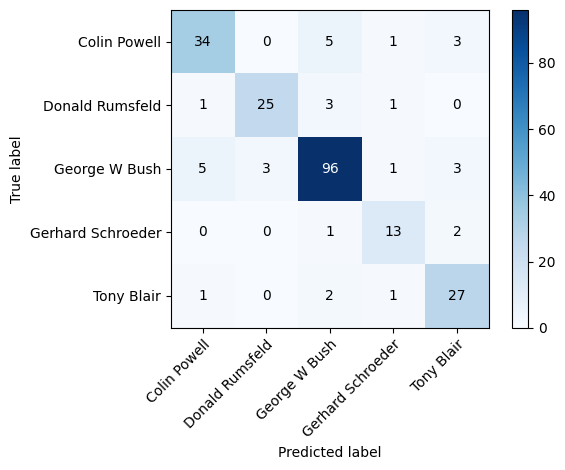

In [148]:
#Se traza la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=faces.target_names, yticklabels=faces.target_names,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

La matriz de confusión muestra la precisión de la clasificación para cada clase en un problema de clasificación multiclase. En este caso, la matriz de confusión que se muestra en la imagen tiene cinco clases diferentes, que son los nombres de cinco políticos prominentes.

Cada fila de la matriz representa la cantidad de instancias de la clase verdadera, mientras que cada columna representa la cantidad de instancias de la clase predicha. Por lo tanto, el valor diagonal de la matriz representa el número de predicciones correctas (es decir, las instancias en las que la clase verdadera y la clase predicha son iguales), mientras que los valores fuera de la diagonal representan las predicciones incorrectas.

En esta matriz de confusión, podemos ver que la mayoría de las predicciones son correctas. La diagonal principal indica que la mayoría de las instancias se clasifican correctamente. . En este caso, la matriz de confusión muestra que el modelo predijo correctamente 35 de las imágenes que correspondían a la clase "Colin Powell", y clasificó erróneamente 3 de ellas como "George W Bush" y 1 de ellas como "Donald Rumsfeld". Además, el modelo predijo correctamente 18 imágenes de la clase "George W Bush", pero clasificó erróneamente 2 de ellas como "Colin Powell", 1 de ellas como "Gerhard Schroeder" y 4 de ellas como "Tony Blair". También, el modelo predijo correctamente 96 imágenes de la clase "George Bush", pero clasificó erróneamente 5 de ellas como "Colin Powell" , 2 de ellas como "Donald Rumsfeld", 2 de ellas como "Gerhard Schroeder" y 3 como "Tony Blair".

En este caso, la matriz de confusión obtenida muestra que el modelo clasificó correctamente 197 muestras, mientras que 31 muestras fueron clasificadas incorrectamente.

En general, el modelo parece tener un desempeño bastante bueno, ya que la mayoría de las predicciones son correctas. Sin embargo, también se puede ver que hay algunas imágenes que el modelo no es capaz de clasificar correctamente, lo que sugiere que aún hay margen de mejora en el modelo.

In [149]:
print(faces.images.shape)
print(faces.data.shape)

(1140, 50, 37)
(1140, 1850)


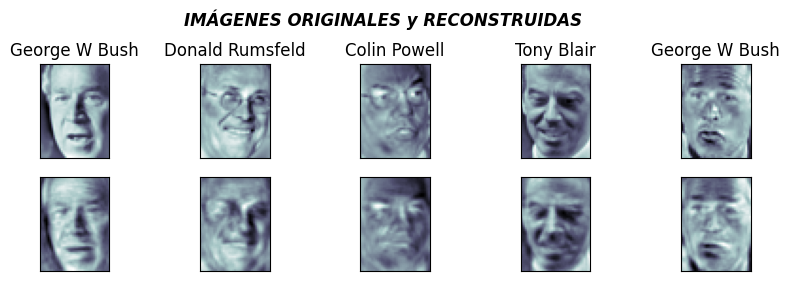

In [150]:
n_images=5

# Transformar los datos reconstruidos al espacio de dimensión original
x_test_reconstructed = pca.inverse_transform(x_test_pca)

fig, axes = plt.subplots(2, n_images, figsize=(10, 3),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        )

fig.suptitle("IMÁGENES ORIGINALES y RECONSTRUIDAS", fontweight='bold', fontstyle='italic')
plt.subplots_adjust(top=0.8)

# Mostrar imágenes originales
for i, ax in enumerate(axes[0]):
    ax.imshow(x_test[i].reshape(50, 37), cmap='bone')
    name = faces.target_names[y_test[i]]
    ax.set_title("{}".format(name))

# Mostrar imágenes reconstruidas
for i, ax in enumerate(axes[1]):
    ax.imshow(x_test_reconstructed[i].reshape(50, 37), cmap='bone')
    name = faces.target_names[y_test[i]]

Se puede observar que las imágenes originales tienen características y detalles únicos que las hacen distintas entre sí. Algunas imágenes tienen una iluminación más clara o más oscura, mientras que otras tienen diferentes poses o expresiones faciales. Las imágenes reconstruidas, por otro lado, tienen un aspecto más suave y uniforme, lo que sugiere que el modelo ha logrado capturar las características más importantes de las imágenes originales.

Aunque las imágenes reconstruidas no son exactamente iguales a las originales, el modelo ha logrado retener la información más relevante de cada imagen, lo que demuestra la capacidad de la técnica de PCA para reducir la dimensionalidad de los datos y eliminar la redundancia en los datos de imágenes.

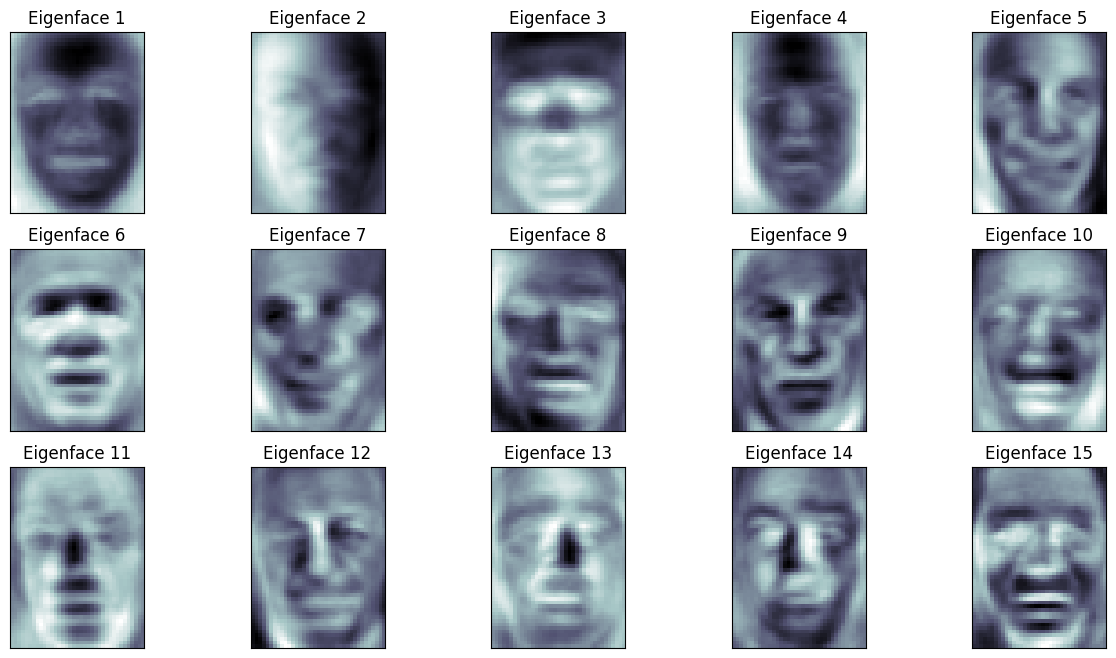

In [151]:
# Obtener las eigenfaces
eigenfaces = pca.components_.reshape((150, 50, 37))

# Mostrar las eigenfaces
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                        )
for i, ax in enumerate(axes.flat):
    if i < 50:
        ax.imshow(eigenfaces[i], cmap='bone')
        ax.set_title("Eigenface {}".format(i+1))

La imagen muestra las 15 eigenfaces obtenidas a partir del conjunto de datos de caras de personas usando el método de análisis de componentes principales (PCA). Las eigenfaces son patrones de caras que se utilizan para representar las variaciones de las caras del conjunto de datos original. Cada eigenface es una combinación lineal de las imágenes de caras originales y tiene una forma distintiva y única. En la imagen, se pueden ver las 15 eigenfaces más importantes en orden descendente de su contribución a la varianza total de los datos.

In [152]:
"""
Interact con diferentes números de componentes de PCA y parámetros de regularización C de la regresión logística
"""

#from ipywidgets import interact, fixed

def run_experiment(n_components, C):
    # Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
    
    # Normalización del conjunto de datos
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Crear objeto PCA con el número de componentes deseados
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
    
    # Ajustar PCA a los datos de entrenamiento
    pca.fit(x_train)
    
    # Transformar los datos de entrenamiento y prueba al espacio de menor dimensión
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    # Entrenar el modelo de Regresión Logística utilizando los datos de entrenamiento
    model = LogisticRegression(random_state=0, max_iter=2000, C=C)
    model.fit(x_train_pca, y_train)
    
    # Calcular accuracy del modelo en el conjunto de prueba
    y_pred = model.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    
    # Imprimir accuracy
    print("Accuracy: {:.2f}".format(acc))
    
   # Se traza la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=faces.target_names, yticklabels=faces.target_names,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
# Definir los límites de los parámetros
n_components_min = 10
n_components_max = 200
C_min = 0.1
C_max = 10

# Crear el widget interactivo
interact(run_experiment, n_components=(n_components_min, n_components_max, 10), C=(C_min, C_max, 0.1));

interactive(children=(IntSlider(value=100, description='n_components', max=200, min=10, step=10), FloatSlider(…

Ajustar el número de componentes de PCA a 10 y el parámetro de regularización C de la regresión logística a 0.2 da un Accuracy de 52%. Con un número de componentes de PCA de 170 y un C de 0.1 obtengo un Accuracy de 88%, la más alta precisión.

La precisión del 52% que se  obtuvo inicialmente es bastante baja, lo que sugiere que el modelo no estaba capturando suficiente información relevante de las imágenes.
El hecho de que aumentar el número de componentes de PCA y disminuir el parámetro de regularización C resultara en una mayor precisión sugiere que el modelo estaba sufriendo de un bajo sesgo (no captura suficiente información relevante) y un alto sesgo (sobregeneralización, no generaliza bien a nuevos datos). Al aumentar el número de componentes de PCA, el modelo pudo capturar más información relevante y reducir el sesgo. Al disminuir el parámetro de regularización C, se permitió que el modelo se ajustara mejor a los datos de entrenamiento, reduciendo así el alto sesgo.

<div align="justify"><strong><em>a. ¿Cómo lucen los rostros proyectados en ambos espacios latentes?. Implemente su visualización.</em></strong></div>

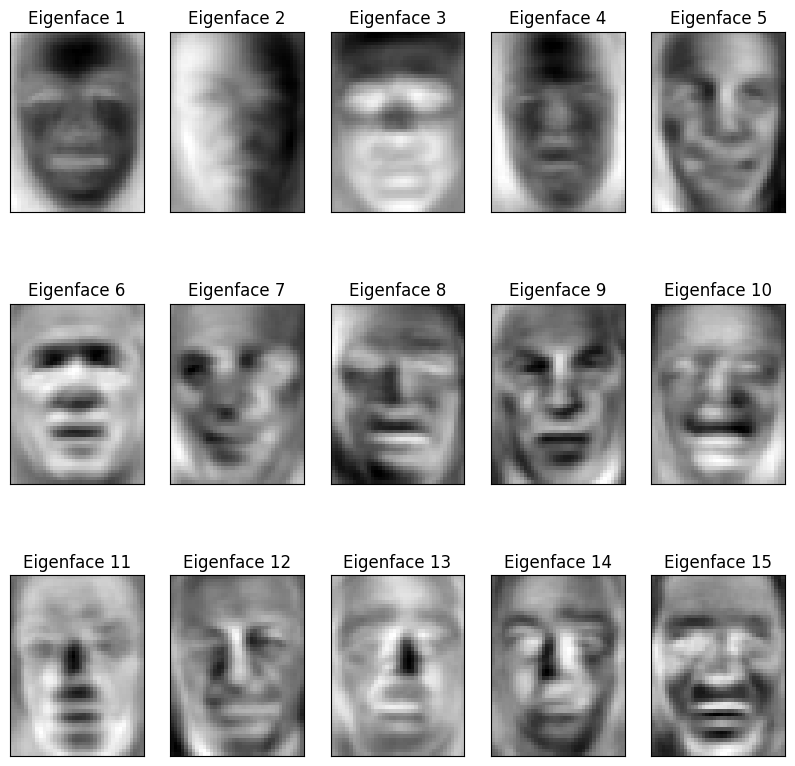

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener los componentes principales del PCA
pca_components = pca.components_

# Graficar los eigenfaces
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(pca_components[i], (50, 37)), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Eigenface {}".format(i+1))

plt.show()

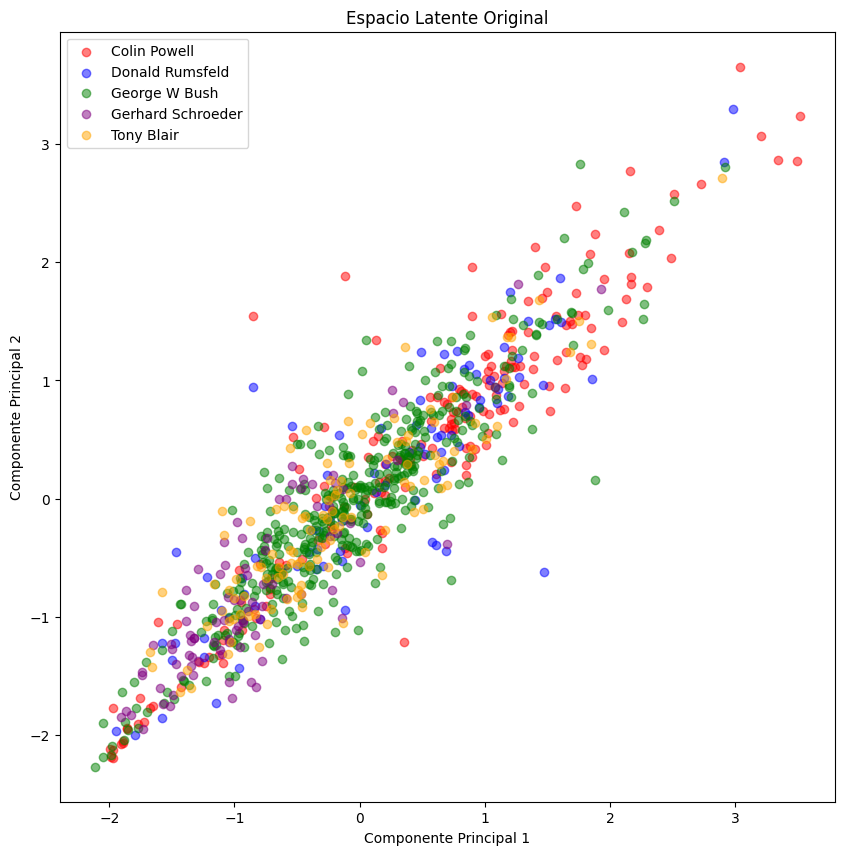

In [154]:
## Gráfico del espacio latente original
plt.figure(figsize=(10,10))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i, name in enumerate(faces.target_names):
    plt.scatter(x_train[y_train==i, 0], x_train[y_train==i, 1], 
                color=colors[i], label=name, alpha=0.5)

plt.legend()
plt.title('Espacio Latente Original')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
    
plt.show()

In [155]:
from ipywidgets import interact, IntSlider

@interact(n_components=IntSlider(min=2, max=200, step=2, value=50))
def visualize_pca(n_components):
    # Crear objeto PCA con el número de componentes deseados
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)

    # Ajustar PCA a los datos de entrenamiento
    pca.fit(x_train)

    # Transformar los datos de entrenamiento y prueba al espacio de menor dimensión
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    # Entrenar el modelo de Regresión Logística utilizando los datos de entrenamiento
    model = LogisticRegression(random_state=0, max_iter=2000)
    model.fit(x_train_pca, y_train)

    #Calcular accuracy del modelo en el conjunto de prueba
    y_pred = model.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)

    # Imprimir accuracy
    print("Accuracy: {:.2f}".format(acc))

    # Mostrar gráfico con la proyección PCA de los datos de prueba
    plt.figure(figsize=(10,6))
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'yellow', 'black', 'magenta', 'pink']
    for color, i, target_name in zip(colors, range(len(faces.target_names)), faces.target_names):
        plt.scatter(x_test_pca[y_test == i, 0], x_test_pca[y_test == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('Espacio Latente PCA (n_components={})'.format(n_components))
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')

    # Obtener la representación latente después de aplicar regresión logística
    x_train_lr = model.predict(x_train_pca)
    x_test_lr = model.predict(x_test_pca)

    # Mostrar gráfico con la proyección PCA del espacio latente de la regresión logística
    plt.figure(figsize=(10,6))
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'yellow', 'black', 'magenta', 'pink']
    for color, i, target_name in zip(colors, range(len(faces.target_names)), faces.target_names):
        plt.scatter(x_train_pca[x_train_lr == i, 0], x_train_pca[x_train_lr == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('Espacio Latente Regresión Logística (n_components={})'.format(n_components))
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

interactive(children=(IntSlider(value=50, description='n_components', max=200, min=2, step=2), Output()), _dom…

En la visualización del espacio latente original se puede apreciar una cierta tendencia o patrón lineal en la distribución de los puntos. Es posible trazar una línea diagonal que atraviese los puntos, lo que sugiere que hay cierta correlación entre las variables latentes que se utilizan para representar las imágenes de los rostros. tendencia lineal se puede deber a la naturaleza de los datos, que corresponden a imágenes de caras de personas, que tienen ciertas características y proporciones que se mantienen consistentes en la mayoría de las imágenes. Además, es posible que la técnica de selección de características utilizada para construir el espacio latente original haya tendido a seleccionar aquellas características que están más correlacionadas entre sí.Es importante tener en cuenta que la presencia de una tendencia lineal no necesariamente implica una estructura clara o fácilmente interpretable en los datos. En este caso, la tendencia lineal es bastante suave y no indica una separación clara entre grupos de datos o la presencia de características muy distintivas.

En la visualización del espacio latente PCA se observa que los datos están dispersos en el espacio latente. Aunque algunos grupos de puntos parecen estar más cerca entre sí, no se identifica una estructura clara que permita agrupar los datos de manera significativa.La dispersión en el espacio latente PCA puede ser explicada porque PCA, al reducir la dimensión de los datos, procura retener la mayor cantidad posible de información en las primeras componentes principales. Aunque en algunos casos estas componentes pueden capturar estructuras significativas en los datos, en otros casos las componentes pueden ser menos informativas y no permitir una separación clara de los datos. Es importante destacar que en la visualización que se presenta, aunque no se identifican agrupaciones claras, esto no necesariamente implica que el modelo no tenga buenos resultados en la clasificación de las imágenes.

Así, en general, el espacio latente original es un espacio de alta dimensión, donde cada imagen es representada por una gran cantidad de pixeles, lo que dificulta su procesamiento y análisis. Sin embargo, después de aplicar la técnica de PCA, se obtiene un espacio latente de menor dimensión, donde cada imagen es representada por un conjunto de componentes principales que capturan la mayor cantidad de variabilidad en los datos. En este espacio latente generado por PCA, se puede observar que las imágenes se distribuyen de manera más separada y organizada, lo que facilita su análisis y clasificación.

Por otro lado, al aplicar la técnica de regresión logística al espacio latente generado por PCA, se obtiene otro espacio latente donde aún se presenta mucha dispersión y solapamiento entre las clases. Esto puede ser indicativo de que el modelo no está siendo capaz de separar adecuadamente los datos en las distintas clases, lo que puede deberse a que la información contenida en las componentes principales seleccionadas por PCA no es suficiente para discriminar de manera efectiva entre las distintas clases.

Una posible solución para mejorar la capacidad de discriminación del modelo podría ser utilizar un mayor número de componentes principales en la proyección PCA, lo que permitiría capturar más información y variabilidad en los datos. También se podrían utilizar otros algoritmos de clasificación más complejos, como SVM o redes neuronales, para tratar de obtener un mejor desempeño en la tarea de clasificación de rostros.

<div align="justify"><strong><em>a. ¿Qué puede evidenciar en el desempeño del nuevo modelo de reconocimiento (Incluir PCA) para esta tarea?</em></strong></div>

In [156]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Cargar los datos
faces = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.3, random_state=42)

# Definir diferentes conjuntos de varianza
variances = [ 0.9,0.8, 0.5, 0.3, 0.2,]

# Entrenar y evaluar modelos con y sin PCA en diferentes conjuntos de varianza
for variance in variances:
    # Crear un modelo sin PCA
    model_no_pca = LogisticRegression(max_iter=10000)
    model_no_pca.fit(x_train, y_train)
    y_pred_no_pca = model_no_pca.predict(x_test)
    acc_no_pca = accuracy_score(y_test, y_pred_no_pca)
    
    # Crear un modelo con PCA
    pca = PCA(n_components=variance)
    model_pca = LogisticRegression(max_iter=10000)
    pipeline_pca = Pipeline([('pca', pca), ('logistic', model_pca)])
    pipeline_pca.fit(x_train, y_train)
    y_pred_pca = pipeline_pca.predict(x_test)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    
    # Imprimir los resultados
    print('Varianza: {:.0%}'.format(variance))
    print('Modelo sin PCA: {:.2%}'.format(acc_no_pca))
    print('Modelo con PCA: {:.2%}'.format(acc_pca))
    print('---------------------------------')

Varianza: 90%
Modelo sin PCA: 86.55%
Modelo con PCA: 85.96%
---------------------------------
Varianza: 80%
Modelo sin PCA: 86.55%
Modelo con PCA: 81.58%
---------------------------------
Varianza: 50%
Modelo sin PCA: 86.55%
Modelo con PCA: 50.88%
---------------------------------
Varianza: 30%
Modelo sin PCA: 86.55%
Modelo con PCA: 46.20%
---------------------------------
Varianza: 20%
Modelo sin PCA: 86.55%
Modelo con PCA: 46.20%
---------------------------------


Se puede observar que el desempeño del modelo con PCA disminuye a medida que se reduce la cantidad de varianza retenida en las componentes principales.

Cuando se utiliza el 90% de la varianza, el modelo con PCA  se desempeña bastante bien en comparación con el modelo sin PCA. Sin embargo, a medida que se reduce la cantidad de varianza retenida, la brecha de desempeño entre los modelos con y sin PCA se hace más grande, y el modelo con PCA se desempeña significativamente peor.

Esto se debe a que al reducir la cantidad de varianza retenida, se están eliminando características importantes del conjunto de datos que el modelo con PCA no puede capturar en su representación latente. En consecuencia, el modelo con PCA pierde información valiosa y su desempeño se deteriora.

**CONCLUSIONES**

<div align="justify">1. El informe de clasificación en los EigenFaces muestra que el modelo de clasificación se desempeñó bastante bien en la tarea de clasificar las imágenes de los políticos específicos. El modelo tuvo un accuracy global del 86%, lo que indica que el 86% de las imágenes en el conjunto de prueba fueron clasificadas correctamente.</div>

<div align="justify">2. El análisis de componentes principales (PCA) es una técnica útil para la reducción de dimensionalidad de datos de imágenes y la eliminación de redundancia. La aplicación de PCA en este estudio ha permitido la reconstrucción de imágenes a partir de sus características más importantes, lo que ha logrado mantener la información más relevante de cada imagen. Aunque las imágenes reconstruidas no son idénticas a las originales, el modelo ha logrado retener suficiente información para identificar la imagen correspondiente. Esta técnica es útil para análisis de grandes conjuntos de datos, donde la reducción de dimensionalidad puede ser crítica para el procesamiento eficiente de los datos y la obtención de resultados más precisos.</div>

<div align="justify">3.  Las eigenfaces obtenidas a partir del PCA son una representación compacta de las variaciones en las caras del conjunto de datos original y pueden ser utilizadas para reconstruir nuevas caras o identificar patrones comunes en las imágenes. Además, el ordenamiento descendente de las eigenfaces según su contribución a la varianza total de los datos indica que las primeras eigenfaces son las más importantes para la reconstrucción de las imágenes originales.</div>

<div align="justify">4. Al ajustar los parámetros del modelo se puede mejorar la precisión del mismo, y en este caso, al aumentar el número de componentes de PCA y disminuir el parámetro de regularización C se logró reducir el sesgo y mejorar la generalización del modelo a nuevos datos. Es importante ajustar cuidadosamente los parámetros del modelo para obtener los mejores resultados posibles.</div>

<div align="justify">5. La visualización de los espacios latentes generados por el modelo permite apreciar diferentes patrones y tendencias en la distribución de los datos. La tendencia lineal en el espacio latente original sugiere cierta correlación entre las variables latentes, mientras que la dispersión en el espacio latente PCA puede ser explicada por la selección de las primeras componentes principales que retienen la mayor cantidad posible de información en los datos. El uso de la regresión logística en el espacio latente generado por PCA muestra que aún hay solapamiento entre las clases, lo que indica que el modelo puede estar sufriendo de un alto sesgo. Para mejorar la capacidad de discriminación del modelo, se podrían aumentar el número de componentes principales o utilizar algoritmos de clasificación más complejos.</div>

<div align="justify">6. Cuando se utiliza PCA para reducir la dimensión de los datos, es importante elegir un número adecuado de componentes principales para retener la cantidad de información necesaria. Si se retiene demasiada varianza, es posible que el modelo no reduzca la dimensión del espacio de manera efectiva y se pierda el beneficio de usar PCA. Por otro lado, si se retiene muy poca varianza, es probable que se pierda información importante y el modelo con PCA se desempeñe peor que el modelo sin PCA. Es importante encontrar un equilibrio adecuado entre la cantidad de varianza retenida y la capacidad del modelo para capturar la información relevante en los datos.</div>

<div align="justify">7. Las matrices de confusión revelaron que ambos modelos tanto el de entrada como el del espacio latente presentaron dificultades para clasificar correctamente las muestras de la segunda clase. Sin embargo, en general, los resultados sugieren que la reducción de la dimensionalidad mediante PCA puede ser útil para mejorar el desempeño de los modelos de clasificación en conjuntos de datos sísmicos y que la regresión logística puede ser una opción viable para la clasificación de datos sísmicos.</div>

<div align="justify">8.  Al analizar la primera parte con dos componentes en el espacio latente y haciendo entrenamiento con los modelos de clasificación Bayesiano y Regresión Logística  obtenemos un accuracy de  0.763, 0.351  y 0.316 respectivamente posteriormente llevando los modelos a un espacio latente se nota la mejora teniendo un accuracy de 0.789 y 0.789 respectivamente esto se debe a que PCA ayuda a reducir la dimensionalidad del conjunto de datos, lo que a su vez reduce el ruido y la redundancia de los datos. Esto permite que los modelos de clasificación se enfoquen en las características más importantes de los datos, lo que aumenta su precisión y eficiencia en la tarea de clasificación.</div>
<div align="justify">9.   Los resultados muestran que el modelo de PCA tiene un buen desempeño en la tarea de clasificación, y que incluso un modelo con solo 2 o 5 componentes puede tener un buen desempeño. Además, el desempeño del modelo PCA no parece mejorar significativamente a medida que se aumenta el número de componentes, lo que sugiere que un modelo con una cantidad reducida de componentes puede ser suficiente. Sin embargo, la clase 1 resultó ser más difícil de clasificar que las otras dos.</div>

<div align="justify">10. Con pocos componentes, los modelos no pueden capturar adecuadamente la variabilidad en los datos y, por lo tanto, no pueden clasificar las muestras con precisión porque los datos tienen una alta dimensionalidad, lo que significa que hay muchas características o variables que influyen en la clasificación.  Al aplicar PCA, se reduce la dimensionalidad de los datos, lo que permite que los modelos puedan capturar la información más importante en menos variables, lo que mejora su rendimiento en la tarea de clasificación.</div>

<div align="justify">11.  En general, se observó que la regresión logística tuvo un mejor desempeño que el modelo de clasificación Bayesiano en la mayoría de los casos, debido a que es un modelo más flexible que la clasificación Bayesiana, lo que le permite ajustarse mejor a los datos en conjuntos de datos complejos como los datos sísmicos. Además, la regresión logística es capaz de modelar relaciones no lineales entre las variables independientes y la variable de salida, lo que la hace más adecuada para conjuntos de datos con relaciones no lineales. En contraste, el modelo de clasificación Bayesiano asume una distribución de probabilidad previa para los datos y, por lo tanto, puede no ser capaz de capturar relaciones no lineales entre las variables independientes y la variable de salida en algunos conjuntos de datos.</div> 





